In this post, I will use the logit regression method to predict default rate.   

# We should have a varibale that show having complete loan or not

In [29]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as plt

sns.set_theme(style="whitegrid")

## Data
To answer the question, I will analyze loan data for 5000 banking system customers in a Middle Eastern country. 

In [3]:
df = pd.read_csv("C:\\Users\\rtava\\OneDrive\\Documents\\Git\\MLProject\\loans_clean.csv")

### Varibales

The following table provide a description for variables in the data set. 

|Variable name |Description| 
|:-----|:-----|
|date_granted |the date which the loan granted|
|label|is =1 if the costumer paid at least one installment with more than 90 days delay|
|installment| number of the requested loan installment|

## Descriptive Statistics

In [4]:
#df=df.loc[data["date_granted"]<20218000]

In [5]:
print("This dataset has", df.shape[0], "records with", df.shape[1], "atributes")
print("About", df.label.mean().round(2) , "of lables was defaulted with label 1") 

This dataset has 5578 records with 33 atributes
About 0.38 of lables was defaulted with label 1


#sns.scatterplot(data, x="installment", y="amount_approved")

df.loc[df['installment']>61, 'installment_group']="less than 60"
df.installment_group.fillna("more", inplace=True)

sns.set_theme(style="whitegrid")
sns.scatterplot(x="installment", y="amount_approved",
                s=5, palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0, hue="installment_group",
                data=df)


In [6]:
df.columns

Index(['national_code', 'date_granted', 'label', 'installment', 'num_loans',
       'age', 'gender', 'marital', 'num_negstatus_2years',
       'num_negstatus_before_2years', 'total_early_payment',
       'total_delayed_payment', 'max_installment_amount', 'oldest_loan_age',
       'complete_last_payment_age', 'num_prev_0_1_year_loans',
       'num_prev_1_3_year_loans', 'guarantor_role',
       'negstatus_guarantor_last_12month',
       'negstatus_guarantor_before_12month', 'completed_loan_ratio',
       'outstanding_debt_ratio', 'past_due_6_month', 'past_due_6_18_month',
       'past_due_18_more_month', 'undue_12_month', 'undue_12_more_month',
       'default_12_month', 'default_12_more_month',
       'worst_negative_status_last_2years', 'current_installments',
       'age_last_negative_status', 'amount_approved'],
      dtype='object')

In [7]:
group_demography = ['age', 'gender', 'marital']
group_requested_load = ['date_granted', 'label', 'installment','amount_approved']
group_repayment_history = ['total_delayed_payment', 'total_early_payment','num_negstatus_2years',
       'num_negstatus_before_2years', 'negstatus_guarantor_last_12month',
       'negstatus_guarantor_before_12month','past_due_6_month', 'past_due_6_18_month',
       'past_due_18_more_month', 'undue_12_month', 'undue_12_more_month',
       'default_12_month', 'default_12_more_month',
       'worst_negative_status_last_2years','age_last_negative_status']
group_financial_history = ['num_loans', 'max_installment_amount', 'oldest_loan_age',
       'complete_last_payment_age', 'num_prev_0_1_year_loans',
       'num_prev_1_3_year_loans', 'guarantor_role',
       'completed_loan_ratio', 'outstanding_debt_ratio', 'current_installments']

In [8]:
all_columns = group_demography + group_requested_load + group_repayment_history + group_financial_history
df_new = df[all_columns];

for c in df_new.columns:
    q1 = df_new[c].quantile(0.05)
    q3 = df_new[c].quantile(0.95)
    iqr = q3-q1
    lower_fence = q1 - 1.5*iqr
    upper_fence = q3 + 1.5*iqr

    for i in range(len(df)):
        if df_new.loc[i, c] < lower_fence or df_new.loc[i, c] > upper_fence:  # if outlier
            df_new.loc[i, "out_" + c] = 1
        else:
            df_new.loc[i, "out_" + c] = 0

out_col = [col for col in df_new.columns if 'out_' in col]
df_new['out'] = df_new[out_col].sum(axis=1)

df_new = df_new.loc[df_new.out==0]
df_new.drop([col for col in df_new.columns if 'out_' in col], axis=1, inplace=True)

In [9]:
df_prep = pd.get_dummies(df_new, columns=['worst_negative_status_last_2years'])

for column in ['worst_negative_status_last_2years_0.0', 
          'worst_negative_status_last_2years_1.0', 
          'worst_negative_status_last_2years_2.0',
          'worst_negative_status_last_2years_3.0']:
        df_prep[column] = df_prep[column].replace({True: 1, False: 0})

<Axes: >

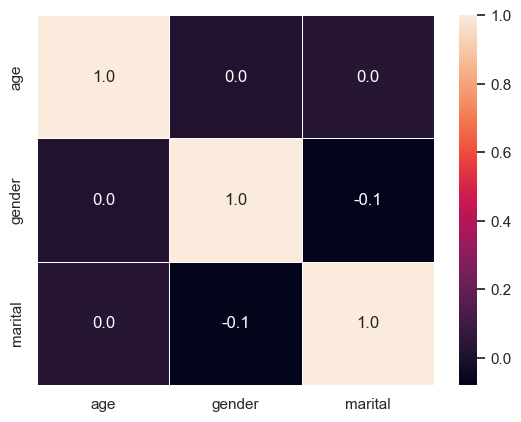

In [76]:
corr = df_prep[['age', 'gender', 'marital']].corr(method = 'pearson')
corr
sns.heatmap(corr,annot=True,fmt=".1f", linewidth=.5)

In [40]:
x_col = ['age', 'installment','amount_approved',
        'total_delayed_payment','num_negstatus_2years',
       'num_negstatus_before_2years','past_due_6_month', 'past_due_6_18_month',
       'past_due_18_more_month', 'undue_12_month', 'undue_12_more_month',
       'num_loans','oldest_loan_age', 'outstanding_debt_ratio',
       'worst_negative_status_last_2years_0.0', 'worst_negative_status_last_2years_1.0', 
       'worst_negative_status_last_2years_2.0', 'worst_negative_status_last_2years_3.0']

#'default_12_month'

In [41]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_prep, test_size=0.2, random_state = 1234)

X_train, y_train = df_train[x_col], df_train['label']
X_test, y_test = df_test[x_col], df_test['label']

print("Train Sample Size:", X_train.shape[0],
      "\nTest Sample Size:", X_test.shape[0])

Train Sample Size: 3832 
Test Sample Size: 958


In [ ]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier 

threshold = 0.4

RF_model = RandomForestClassifier(random_state=1234, max_depth = 20, n_estimators=100, class_weight='balanced')
RF_model.fit(X_train,y_train)
y_prob_RF = RF_model.predict_proba(X_test)
y_pred_RF = (y_prob_RF[:,1] >= threshold).astype('int')
Accuracy_RF = metrics.accuracy_score(y_test, y_pred_RF)
F1_RF = metrics.f1_score(y_test, y_pred_RF)
AUC = metrics.roc_auc_score(y_test, y_pred_RF)
clas_report = metrics.classification_report(y_test, y_pred_RF)

In [73]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

Fscore = []
thrsh = []
for i in range(10,65,1):
    threshold = i/100
    thrsh.append(threshold)

    RF_model = RandomForestClassifier(random_state=1234, max_depth = 20, n_estimators=100, class_weight='balanced')
    RF_model.fit(X_train,y_train)
    y_prob_RF = RF_model.predict_proba(X_test)
    y_pred_RF = (y_prob_RF[:,1] >= threshold).astype('int')
    Accuracy_RF = metrics.accuracy_score(y_test, y_pred_RF)
    Fscore.append(metrics.f1_score(y_test, y_pred_RF))
    AUC = metrics.roc_auc_score(y_test, y_pred_RF)
    clas_report = metrics.classification_report(y_test, y_pred_RF)

<Axes: >

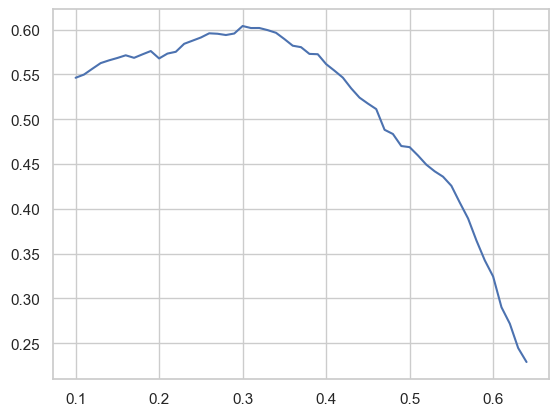

In [74]:
sns.lineplot(x=thrsh, y=Fscore)

RF Accuracy: 0.662839248434238 
F1 Score: 0.5616045845272206 
AUC_ROC: 0.547780471176426


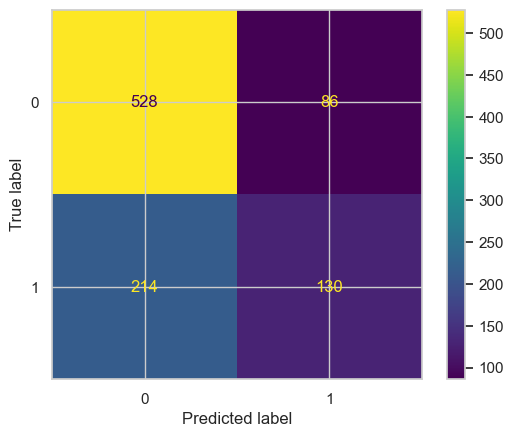

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


print("RF Accuracy:",Accuracy_RF, "\nF1 Score:", F1_RF, "\nAUC_ROC:", AUC)
ConfusionMatrixDisplay.from_estimator(RF_model, X_test, y_test);